In [1]:
#------------------------------------#
#------------- packages--------------#
#------------------------------------#

import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import math
# Calculate the correlation coefficient
from scipy import stats
from scipy.stats import shapiro 
from scipy.stats import lognorm
# import ttest_ind from scipy.stats
from scipy.stats import ttest_ind

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

# from sklearn.preprocessing import MinMaxScaler

# show multiple outputs in a cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last_expr"


import cufflinks as cf
from plotly import plot
cf.go_offline()
import os
from os import read

In [2]:
#------------------------------------#
#-------read check-in survey---------#
#------------------------------------#

survey_daily = pd.read_csv("datafiles/daily.csv",parse_dates=["StartDate","EndDate","Q15","Q6"])
# survey_daily["date"] = merged_fit_survey["RecordedDate"].dt.date
# merged_fit_survey["surveyTime"] = pd.to_datetime(merged_fit_survey["RecordedDate"]).dt.time

incomp = survey_daily[(survey_daily['Finished'] == False)].index
survey_daily.drop(incomp, inplace=True)
# len(survey_daily)
survey_daily=survey_daily.drop(['RecipientLastName','StartDate','Progress','Duration (in seconds)','Finished','RecordedDate','LocationLatitude','LocationLongitude'], axis=1)
survey_daily['date'] = survey_daily['EndDate'].dt.date
# attention check
survey_daily=survey_daily.drop(['Q33_1', 'Q34_1','Q35_1','Q36_1','Q37_1'], axis=1)
survey_daily.reset_index(inplace=True)
survey_daily = survey_daily.rename(columns = {'index':'survey_index','Q15':'rep_bedtime','Q6':'rep_wakeup'})

# convert EndDate,rep_bedtime,rep_wakeup to datetime
survey_daily['EndDate'] = pd.to_datetime(survey_daily['EndDate'])
survey_daily['rep_bedtime'] = pd.to_datetime(survey_daily['rep_bedtime'])
survey_daily['rep_wakeup'] = pd.to_datetime(survey_daily['rep_wakeup'])

# calculate reported sleep duration
survey_daily['repDuration'] = survey_daily['rep_wakeup'] - survey_daily['rep_bedtime']
survey_daily['repDuration'] = survey_daily['repDuration'].dt.total_seconds()

survey_daily.head()

,survey_index,Unnamed: 0,EndDate,Q3_1,Q4,rep_bedtime,rep_wakeup,Q28,Q29,Q22_1,Q23_1,Q27_1,Q34,Q34_6_TEXT,Q35,pid,date,repDuration
0,0,0,2022-04-27 10:15:38,5.0,None,2022-04-27 00:30:00,2022-04-27 07:20:00,Did not exercise,"My Friends,My colleagues/classsmates/students",NaN,4.0,5.0,"Neutral,Stressed",NaN,Work,edr,2022-04-27,24600.0
1,1,1,2022-04-27 12:55:08,4.0,None,2022-04-27 00:40:00,2022-04-27 09:00:00,In the afternoon,"My Friends,My colleagues/classsmates/students",NaN,NaN,5.0,Neutral,NaN,Work,egl,2022-04-27,30000.0
2,2,2,2022-04-27 14:13:37,NaN,Twice,2022-04-27 02:35:00,2022-04-27 10:30:00,In the evening,"My Friends,New people",2.0,3.0,3.0,Stressed,NaN,Work,uja,2022-04-27,28500.0
3,3,3,2022-04-28 11:55:49,3.0,Twice,2022-04-28 03:15:00,2022-04-28 10:30:00,Did not exercise,My Friends,4.0,3.0,3.0,"Neutral,Sadness,Frustrated",NaN,"Work,Sleep",uja,2022-04-28,26100.0
4,4,4,2022-04-28 13:51:34,5.0,None,2022-04-28 02:00:00,2022-04-28 10:00:00,In the evening,"My Family,My Friends,My colleagues/classsmates...",5.0,NaN,6.0,"Neutral,Happiness",NaN,"Work,Personal",edr,2022-04-28,28800.0


## Step Count from Fitbit

In [3]:
#------------------------------------#
#----------- read step data ---------#
#------------------------------------#

all_step = []

for r,d,f in os.walk("datafiles/lll_fitbit_data"):
    for file in f:
        if file.endswith("steps.csv"):
            temp = pd.read_csv(os.path.join(r,file),parse_dates=["pid"])
            #temp["value"] = (temp["value"] - temp["value"].min()) 
            all_step.append(temp)

all_step = pd.concat(all_step)
all_step.columns = ["pid","Timestamp","value"]
# Convert to Datetime object
all_step['Timestamp'] = pd.to_datetime(all_step['Timestamp'], format="%Y-%m-%d %H:%M:%S")
all_step["day"] = all_step["Timestamp"].dt.day_name()
all_step["date"] = pd.to_datetime(all_step["Timestamp"]).dt.date

# remove participants n3f and iyl
all_step = all_step[all_step['pid'] != 'iyl']
all_step = all_step[all_step['pid'] != 'n3f']

all_step = all_step.sort_values(by=['pid','Timestamp'])
# rename value to steps
all_step = all_step.rename(columns = {'value':'steps'})

all_step.head()

,pid,Timestamp,steps,day,date
0,edr,2022-04-26 00:00:00,0,Tuesday,2022-04-26
1,edr,2022-04-26 00:01:00,0,Tuesday,2022-04-26
2,edr,2022-04-26 00:02:00,0,Tuesday,2022-04-26
3,edr,2022-04-26 00:03:00,0,Tuesday,2022-04-26
4,edr,2022-04-26 00:04:00,0,Tuesday,2022-04-26


## Sleep Data SleepAnalysis.ipynb

In [4]:
# read slp.csv
slp = pd.read_csv("processed_data/slp.csv",parse_dates=["wakeDate","bedtime","wakeup"])
slp.head()

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,light,rem,sleep,Q4,rep_bedtime,rep_wakeup
0,edr,0,2022-04-27,Wednesday,2022-04-27 00:51:00,2022-04-27 07:41:00,24600.0,6.550000,0.418773,3540,13080,6960,5.0,None,2022-04-27 00:30:00,2022-04-27 07:20:00
1,edr,1,2022-04-28,Thursday,2022-04-28 01:51:00,2022-04-28 10:30:00,31140.0,7.633333,0.275766,6060,15480,5940,5.0,None,2022-04-28 02:00:00,2022-04-28 10:00:00
2,edr,2,2022-04-29,Friday,2022-04-29 01:13:00,2022-04-29 09:07:30,28470.0,7.475000,0.321060,4110,16260,6540,5.0,None,2022-04-29 01:08:00,2022-04-29 09:04:00
3,edr,5,2022-05-02,Monday,2022-05-02 00:59:00,2022-05-02 08:27:00,26880.0,6.916667,0.328000,5760,12990,6150,5.0,None,2022-05-02 01:00:00,2022-05-02 08:20:00
4,edr,6,2022-05-03,Tuesday,2022-05-03 01:13:00,2022-05-03 08:22:30,25770.0,6.250000,0.315789,2100,15000,5400,2.0,None,2022-05-03 01:04:00,2022-05-03 08:10:00


In [5]:
# number of participants
slp['pid'].unique()

array(['edr', 'egl', 'h9u', 'heh', 'lpz', 'mr1', 'oyb', 'ssg', 'uja',
       'xil'], dtype=object)

In [6]:
# get day before wakeDate
slp['day_before'] = slp['wakeDate'] - timedelta(days=1)
slp['day_before'] = slp['day_before'].dt.date
slp.head()

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,light,rem,sleep,Q4,rep_bedtime,rep_wakeup,day_before
0,edr,0,2022-04-27,Wednesday,2022-04-27 00:51:00,2022-04-27 07:41:00,24600.0,6.550000,0.418773,3540,13080,6960,5.0,None,2022-04-27 00:30:00,2022-04-27 07:20:00,2022-04-26
1,edr,1,2022-04-28,Thursday,2022-04-28 01:51:00,2022-04-28 10:30:00,31140.0,7.633333,0.275766,6060,15480,5940,5.0,None,2022-04-28 02:00:00,2022-04-28 10:00:00,2022-04-27
2,edr,2,2022-04-29,Friday,2022-04-29 01:13:00,2022-04-29 09:07:30,28470.0,7.475000,0.321060,4110,16260,6540,5.0,None,2022-04-29 01:08:00,2022-04-29 09:04:00,2022-04-28
3,edr,5,2022-05-02,Monday,2022-05-02 00:59:00,2022-05-02 08:27:00,26880.0,6.916667,0.328000,5760,12990,6150,5.0,None,2022-05-02 01:00:00,2022-05-02 08:20:00,2022-05-01
4,edr,6,2022-05-03,Tuesday,2022-05-03 01:13:00,2022-05-03 08:22:30,25770.0,6.250000,0.315789,2100,15000,5400,2.0,None,2022-05-03 01:04:00,2022-05-03 08:10:00,2022-05-02


### Merge FitBit Sleep data with Daily Surveys

In [7]:
# merge slp and survey_daily on pid and slpDate
mergedfit = pd.merge(slp, survey_daily, how='left', left_on=['pid','day_before'], right_on = ['pid','date'])
mergedfit.head()

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,...,Q28,Q29,Q22_1,Q23_1,Q27_1,Q34,Q34_6_TEXT,Q35,date,repDuration
0,edr,0,2022-04-27,Wednesday,2022-04-27 00:51:00,2022-04-27 07:41:00,24600.0,6.550000,0.418773,3540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,edr,1,2022-04-28,Thursday,2022-04-28 01:51:00,2022-04-28 10:30:00,31140.0,7.633333,0.275766,6060,...,Did not exercise,"My Friends,My colleagues/classsmates/students",NaN,4.0,5.0,"Neutral,Stressed",NaN,Work,2022-04-27,24600.0
2,edr,2,2022-04-29,Friday,2022-04-29 01:13:00,2022-04-29 09:07:30,28470.0,7.475000,0.321060,4110,...,In the evening,"My Family,My Friends,My colleagues/classsmates...",5.0,NaN,6.0,"Neutral,Happiness",NaN,"Work,Personal",2022-04-28,28800.0
3,edr,5,2022-05-02,Monday,2022-05-02 00:59:00,2022-05-02 08:27:00,26880.0,6.916667,0.328000,5760,...,In the afternoon,My Friends,4.0,NaN,6.0,Neutral,NaN,Work,2022-05-01,32400.0
4,edr,6,2022-05-03,Tuesday,2022-05-03 01:13:00,2022-05-03 08:22:30,25770.0,6.250000,0.315789,2100,...,Did not exercise,"My Family,My Friends,My colleagues/classsmates...",4.0,4.0,6.0,Neutral,NaN,Work,2022-05-02,26400.0


In [8]:
mergedfit.columns

Index(['pid', 'group', 'wakeDate', 'day_name', 'bedtime', 'wakeup', 'duration',
       'TST', 'REM:nREM', 'deep', 'light', 'rem', 'sleep', 'Q4_x',
       'rep_bedtime_x', 'rep_wakeup_x', 'day_before', 'survey_index',
       'Unnamed: 0', 'EndDate', 'Q3_1', 'Q4_y', 'rep_bedtime_y',
       'rep_wakeup_y', 'Q28', 'Q29', 'Q22_1', 'Q23_1', 'Q27_1', 'Q34',
       'Q34_6_TEXT', 'Q35', 'date', 'repDuration'],
      dtype='object')

In [9]:
# remove unecessary columns
merged = mergedfit.drop(['Q3_1', 'Q4_y', 'rep_bedtime_y', 'rep_wakeup_y', 'repDuration', 'date'], axis=1)
# remove _x from column names
merged.columns = merged.columns.str.replace('_x', '')
merged.columns

Index(['pid', 'group', 'wakeDate', 'day_name', 'bedtime', 'wakeup', 'duration',
       'TST', 'REM:nREM', 'deep', 'light', 'rem', 'sleep', 'Q4', 'rep_bedtime',
       'rep_wakeup', 'day_before', 'survey_index', 'Unnamed: 0', 'EndDate',
       'Q28', 'Q29', 'Q22_1', 'Q23_1', 'Q27_1', 'Q34', 'Q34_6_TEXT', 'Q35'],
      dtype='object')

In [10]:
# how many sleep observations have no survey data
print(merged[merged['survey_index'].isnull()].shape)
print(merged.shape)

(66, 28)
(434, 28)


In [11]:
# remove observations with no survey data
merged = merged[merged['survey_index'].notna()]
merged.shape

(368, 28)

In [12]:
# rename 
merged.rename(columns={'Q3_1':'sleep','Q22_1':'stress','Q23_1':'productivity','Q28':'activity'}, inplace=True)

In [13]:
# how many null values in sleep, stress, productivity, activity
# how many null values in sleep, stress, productivity, activity
print("Number of null values in sleep:", merged['sleep'].isnull().sum())
print("Number of null values in stress:", merged['stress'].isnull().sum())
print("Number of null values in productivity:", merged['productivity'].isnull().sum())
print("Number of null values in activity:", merged['activity'].isnull().sum())

Number of null values in sleep: 0
Number of null values in stress: 57
Number of null values in productivity: 59
Number of null values in activity: 1


In [14]:
# impute missing values for stress, and productivity with default values
merged['stress'].fillna(3, inplace=True)
merged['productivity'].fillna(3, inplace=True)
# don't need to impute the activity bc the form is a checkbox and not likert

In [15]:
# rows by pid
merged.groupby('pid').size()

pid
edr    27
egl    44
h9u    58
heh    53
lpz    48
mr1    28
oyb    19
ssg    26
uja    33
xil    32
dtype: int64

In [16]:
# print mean and std of count
print("Mean of count:", merged.groupby('pid').size().mean())
print("Std of count:", merged.groupby('pid').size().std())

Mean of count: 36.8
Std of count: 13.053735097664577


In [17]:
# proportion of observations with sleep duration between 7 to 9 hours in seconds
merged[(merged['duration'] >= 25200) & (merged['duration'] <= 32400)].shape[0]/merged.shape[0]

0.532608695652174

In [18]:
# REM:nREM ratio between .25 and .33
merged[(merged['REM:nREM'] >= .25) & (merged['REM:nREM'] <= .33)].shape[0]/merged.shape[0]

0.3342391304347826

## Get Step Count

In [19]:
# get pid, wakeDate, bedtime, and wakeup from slpfilt and make it a dataframe
# ranges = slpfilt[['pid','wakeDate','bedtime','wakeup']]

# chunk step data based on time difference between rows being greater then 6000 sec
pids = all_step["pid"].unique()

step = []

# group by pid and minute and sum step count 
for pid in pids:
    df = all_step[all_step["pid"] == pid]
    df = df.groupby(['pid','date'])['steps'].sum().reset_index()
    step.append(df)

step = pd.concat(step).reset_index(drop=True)

step.head()

,pid,date,steps
0,edr,2022-04-26,5835
1,edr,2022-04-27,14713
2,edr,2022-04-28,4316
3,edr,2022-04-29,7821
4,edr,2022-04-30,474


In [20]:
# merge step count with merged slp and survey data
slpsteps = merged.merge(step, how='left', left_on=['pid','day_before'], right_on=['pid','date'])
slpsteps.head()

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,...,activity,Q29,stress,productivity,Q27_1,Q34,Q34_6_TEXT,Q35,date,steps
0,edr,1,2022-04-28,Thursday,2022-04-28 01:51:00,2022-04-28 10:30:00,31140.0,7.633333,0.275766,6060,...,Did not exercise,"My Friends,My colleagues/classsmates/students",3.0,4.0,5.0,"Neutral,Stressed",NaN,Work,2022-04-27,14713.0
1,edr,2,2022-04-29,Friday,2022-04-29 01:13:00,2022-04-29 09:07:30,28470.0,7.475000,0.321060,4110,...,In the evening,"My Family,My Friends,My colleagues/classsmates...",5.0,3.0,6.0,"Neutral,Happiness",NaN,"Work,Personal",2022-04-28,4316.0
2,edr,5,2022-05-02,Monday,2022-05-02 00:59:00,2022-05-02 08:27:00,26880.0,6.916667,0.328000,5760,...,In the afternoon,My Friends,4.0,3.0,6.0,Neutral,NaN,Work,2022-05-01,3034.0
3,edr,6,2022-05-03,Tuesday,2022-05-03 01:13:00,2022-05-03 08:22:30,25770.0,6.250000,0.315789,2100,...,Did not exercise,"My Family,My Friends,My colleagues/classsmates...",4.0,4.0,6.0,Neutral,NaN,Work,2022-05-02,13436.0
4,edr,7,2022-05-04,Wednesday,2022-05-04 01:24:30,2022-05-04 08:37:30,25980.0,6.683333,0.442446,3750,...,In the evening,"My Friends,My colleagues/classsmates/students",3.0,3.0,3.0,"Neutral,Stressed",NaN,Work,2022-05-03,14334.0


In [21]:
# for each participant, normalize their step count
slpsteps['steps_norm'] = slpsteps.groupby('pid')['steps'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_83363/3914235086.py:2: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [22]:
# standardize step count for each participant
slpsteps['steps_std'] = slpsteps.groupby('pid')['steps'].apply(lambda x: (x - x.mean()) / x.std())

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_83363/95094488.py:2: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



## Other daily measures from Daily Survey

In [23]:
# recode for Q28: 'Did not exercise' = 1, 'In the morning' = 2, 'In the afternoon' = 3, 'In the evening' = 4, 'In the morning,In the afternoon' = 5, 
# 'In the morning,In the evening' = 6, 'In the afternoon,In the evening' = 7, 'In the morning,In the afternoon,In the evening' = 8 
# otherdaily['Q28'] = otherdaily['Q28'].replace(['Did not exercise','In the morning','In the afternoon','In the evening'],[1,2,3,4])
# otherdaily['Q28'] = otherdaily['Q28'].replace(['In the morning,In the afternoon','In the morning,In the evening','In the afternoon,In the evening'],[5,6,7])
# otherdaily['Q28'] = otherdaily['Q28'].replace(['In the morning,In the afternoon,In the evening'],[8])

# 'Q3_1':'sleep','Q22_1':'stress','Q23_1':'productivity','Q28':'activity'
#  QUESTION - should i group no exercise vs one time a day vs two times a day vs three times a day?
slpsteps['activity'] = slpsteps['activity'].replace(['Did not exercise'],[0])
slpsteps['activity'] = slpsteps['activity'].replace(['In the morning','In the afternoon','In the evening'],[1,1,1])
slpsteps['activity'] = slpsteps['activity'].replace(['In the morning,In the afternoon','In the morning,In the evening','In the afternoon,In the evening'],[2,2,2])
slpsteps['activity'] = slpsteps['activity'].replace(['In the morning,In the afternoon,In the evening'],[3])

In [24]:
slpsteps.groupby('pid').size()

pid
edr    27
egl    44
h9u    58
heh    53
lpz    48
mr1    28
oyb    19
ssg    26
uja    33
xil    32
dtype: int64

In [25]:
# find number of rows in dataframe
print(slpsteps.shape)

# find NA values for each column
slpsteps.isna().sum()
# 1 missing value for activity
# 60 missing values for Q22_1 ; 67
# 71 missing values for Q23_1 ; 71

(368, 32)


pid               0
group             0
wakeDate          0
day_name          0
bedtime           0
wakeup            0
duration          0
TST               0
REM:nREM          5
deep              0
light             0
rem               0
sleep             0
Q4                0
rep_bedtime       0
rep_wakeup        0
day_before        0
survey_index      0
Unnamed: 0        0
EndDate           0
activity          1
Q29               0
stress            0
productivity      0
Q27_1            54
Q34               0
Q34_6_TEXT      340
Q35               2
date              1
steps             1
steps_norm        1
steps_std         1
dtype: int64

In [26]:
# sort by pid and date and reset index
slpsteps = slpsteps.sort_values(by=['pid','day_before']).reset_index(drop=True)

In [27]:
# days of the week
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

In [28]:
# get average stress score for each participant for each day_name
df = slpsteps.groupby(['pid','day_name'])['stress'].mean().reset_index()
# get average productivity score for each participant for each day_name and add to df
df['productivity'] = slpsteps.groupby(['pid','day_name'])['productivity'].mean().reset_index()['productivity']
# get average physical activity for each participant for each day_name and add to df
df['activity'] = slpsteps.groupby(['pid','day_name'])['activity'].mean().reset_index()['activity']
# get average REM:nREM ratio for each participant for each day_name and add to df
df['REM:nREM'] = slpsteps.groupby(['pid','day_name'])['REM:nREM'].mean().reset_index()['REM:nREM']

# day_name as categorical variable days
df['day_name'] = pd.Categorical(df['day_name'], categories=days, ordered=True)
# sort by pid and day_name
df = df.sort_values(by=['pid','day_name']).reset_index(drop=True)

df

,pid,day_name,stress,productivity,activity,REM:nREM
0,edr,Monday,4.333333,2.666667,0.666667,0.335324
1,edr,Tuesday,3.500000,4.000000,0.333333,0.321083
2,edr,Wednesday,3.285714,3.428571,0.571429,0.278940
3,edr,Thursday,2.600000,4.200000,0.400000,0.428664
4,edr,Friday,5.000000,3.000000,0.750000,0.344109
...,...,...,...,...,...,...
64,xil,Wednesday,4.000000,2.000000,0.500000,0.351309
65,xil,Thursday,3.666667,2.666667,0.666667,0.309037
66,xil,Friday,4.250000,3.000000,0.750000,0.363773
67,xil,Saturday,3.500000,2.750000,0.500000,0.369542


In [29]:
# get pid, wakeDate, duration, activity, stress. producitivity, steps
daily_measures = slpsteps[['pid','wakeDate','duration', 'TST', 'REM:nREM', 'sleep','activity','stress','productivity','steps']]
# sort by pid and wakeDate
daily_measures = daily_measures.sort_values(by=['pid','wakeDate']).reset_index(drop=True)

In [30]:
# to csv
daily_measures.to_csv("processed_data/daily_measures.csv", index=False)

In [31]:
# get the delta t for each participant
daily_measures['delta_t'] = daily_measures.groupby('pid')['wakeDate'].diff()
daily_measures.groupby('pid')['delta_t'].mean()

pid
edr   1 days 21:13:50.769230769
egl   1 days 07:48:50.232558139
h9u             1 days 00:00:00
heh             1 days 00:00:00
lpz   1 days 05:37:01.276595744
mr1             1 days 22:13:20
oyb             2 days 16:00:00
ssg             1 days 20:09:36
uja             1 days 12:45:00
xil   1 days 16:15:29.032258064
Name: delta_t, dtype: timedelta64[ns]

Some participants have a greater time difference between observations and that may be due to breaks in wearing the watch or no response for the daily surveys. For structural equation modeling and other analysis methods, it would be better for the data of each participant to have roughly equivalent delta T. We will proceed to clean the data.

In [32]:
def reindex_participant(participant_df):
    min_date = participant_df['wakeDate'].min()
    max_date = participant_df['wakeDate'].max()
    participant_dates = participant_df['wakeDate'].unique()  # Existing dates for the participant
    all_dates = pd.date_range(min_date, max_date, freq='1D')  # Fixed frequency of 1 day
    
    # Ensure uniqueness in index labels
    participant_df = participant_df.set_index('wakeDate')
    participant_df = participant_df[~participant_df.index.duplicated(keep='first')]
    
    # Create a DataFrame with all dates for the participant
    all_dates_df = pd.DataFrame(index=all_dates)
    all_dates_df['pid'] = participant_df['pid'].iloc[0]  # Fill 'pid' column
    
    # Merge to retain all dates with NaN values for missing dates
    merged_df = all_dates_df.merge(participant_df, how='left', left_index=True, right_index=True)
    
    # Reset index to have 'wakeDate' as a column again
    merged_df = merged_df.reset_index()
    
    return merged_df

# Apply the reindexing function to each participant's data
result_df = daily_measures.groupby('pid').apply(reindex_participant).reset_index(drop=True)
# rename index to wakeDate and pid_x to pid
result_df = result_df.rename(columns = {'index':'wakeDate','pid_x':'pid'})
# remove pid_y
result_df = result_df.drop(['pid_y'], axis=1)
# recalculate delta_t
result_df['delta_t'] = result_df.groupby('pid')['wakeDate'].diff()
# remove delta_t column
result_df = result_df.drop(['delta_t'], axis=1)
result_df.head()

,wakeDate,pid,duration,TST,REM:nREM,sleep,activity,stress,productivity,steps
0,2022-04-28,edr,31140.0,7.633333,0.275766,5.0,0.0,3.0,4.0,14713.0
1,2022-04-29,edr,28470.0,7.475000,0.321060,5.0,1.0,5.0,3.0,4316.0
2,2022-04-30,edr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-01,edr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-02,edr,26880.0,6.916667,0.328000,5.0,1.0,4.0,3.0,3034.0


In [33]:
# standardize steps for each participant
result_df['steps_std'] = result_df.groupby('pid')['steps'].apply(lambda x: (x - x.mean()) / x.std())
# standardize TST for each participant
result_df['TST_std'] = result_df.groupby('pid')['TST'].apply(lambda x: (x - x.mean()) / x.std())
# # to csv
# result_df.to_csv('padded_df_std.csv', index=False)

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_83363/3763149472.py:2: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_83363/3763149472.py:4: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



For some participants, some breaks between observations were fairly long so multipple rows of NaN data were inserted. We create the following function such to reduce the amount of padding that has originally been inserted.

In [34]:
def reduce_padding(participant_df):
    chunks = []
    chunk_start = None
    chunk_end = None
    for index, row in participant_df.iterrows():
        # Check if all values except for 'wakeDate' and 'pid' are NaN
        if row.iloc[2:].isnull().all():
            if chunk_start is None:
                chunk_start = index
                chunk_end = index
            else:
                chunk_end = index
        else:
            if chunk_start is not None:
                chunks.append((chunk_start, chunk_end))
                chunk_start = None
                chunk_end = None

    # If the NaN values continue till the end of the DataFrame
    if chunk_start is not None:
        chunks.append((chunk_start, chunk_end))

    # Filter chunks and keep only the first row if more than 3 rows exist
    for start, end in chunks:
        if end - start + 1 < 3:
            participant_df = participant_df.drop(index=range(start, end + 1))
        elif end - start + 1 >= 3:
            participant_df = participant_df.drop(index=range(start + 1, end + 1))

    return participant_df

# Apply the reduce_padding function to each participant's data
result_df = result_df.groupby('pid').apply(reduce_padding).reset_index(drop=True)

In [35]:
# to csv
result_df.to_csv("processed_data/red_padded_df.csv", index=False)

In [36]:
# count of NA rows for each participant for duration including 0s
nans = result_df[result_df['duration'].isnull()].groupby('pid').size().to_frame('NaNs')
# count of total rows for each participant
total = result_df.groupby('pid').size().to_frame('total')
# merge nans to total on pid
prob = pd.merge(nans, total, how='left', left_on=['pid'], right_on = ['pid'])
# calculate proportion of NA rows for each participant
prob['prop'] = prob['NaNs']/prob['total']
prob

,NaNs,total,prop
pid,,,
edr,2,29,0.068966
egl,2,46,0.043478
lpz,2,49,0.040816
mr1,3,31,0.096774
oyb,4,23,0.173913
ssg,3,29,0.103448
uja,2,35,0.057143
xil,2,34,0.058824


In [37]:
# count of total rows for each participant
result_df.groupby('pid').size()

pid
edr    29
egl    46
h9u    58
heh    53
lpz    49
mr1    31
oyb    23
ssg    29
uja    35
xil    34
dtype: int64

In [38]:
daily_measures.groupby('pid').size()
# unique values of productivity for each participant
daily_measures.groupby('pid')['productivity'].unique()

pid
edr         [4.0, 3.0, 2.0, 5.0]
egl              [3.0, 2.0, 4.0]
h9u    [4.0, 3.0, 2.0, 5.0, 1.0]
heh    [4.0, 3.0, 2.0, 1.0, 5.0]
lpz              [4.0, 3.0, 2.0]
mr1                        [3.0]
oyb    [4.0, 3.0, 1.0, 5.0, 2.0]
ssg    [1.0, 3.0, 2.0, 4.0, 5.0]
uja              [3.0, 4.0, 2.0]
xil         [4.0, 1.0, 3.0, 2.0]
Name: productivity, dtype: object

### Ratings of Sleep, Stress and Productivity across Day of the Week

In [39]:
# plot stress for each participant for each day_name ordered from Monday to Sunday
# order x axis day_name by day of the week
fig = px.box(slpsteps, x="day_name", y="stress", color="pid", #points="all",
                labels={
                    "stress": "Stress",
                    "day_name": "Day of Week",
                    "pid": "Participants"
                })
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig.show()


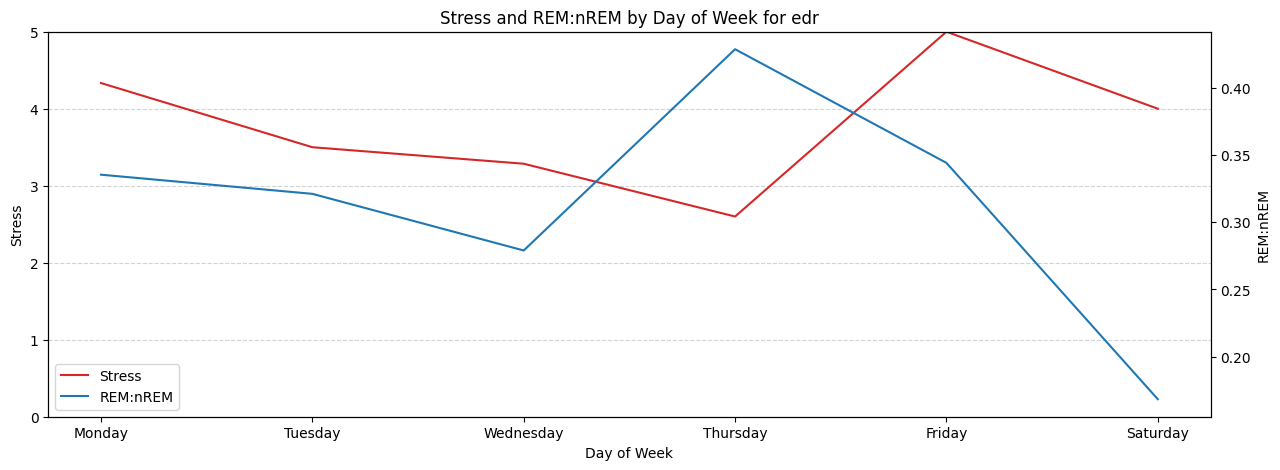

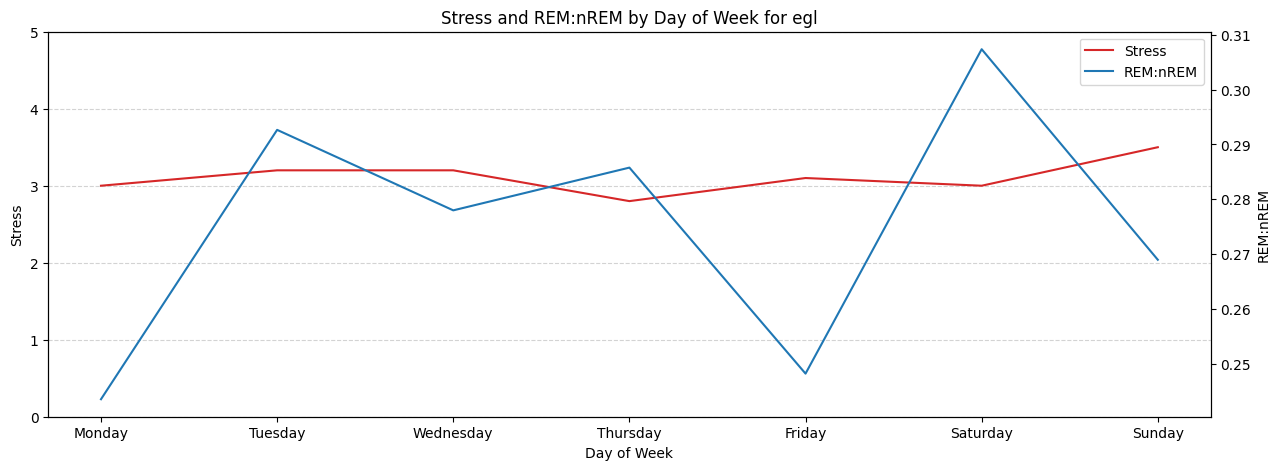

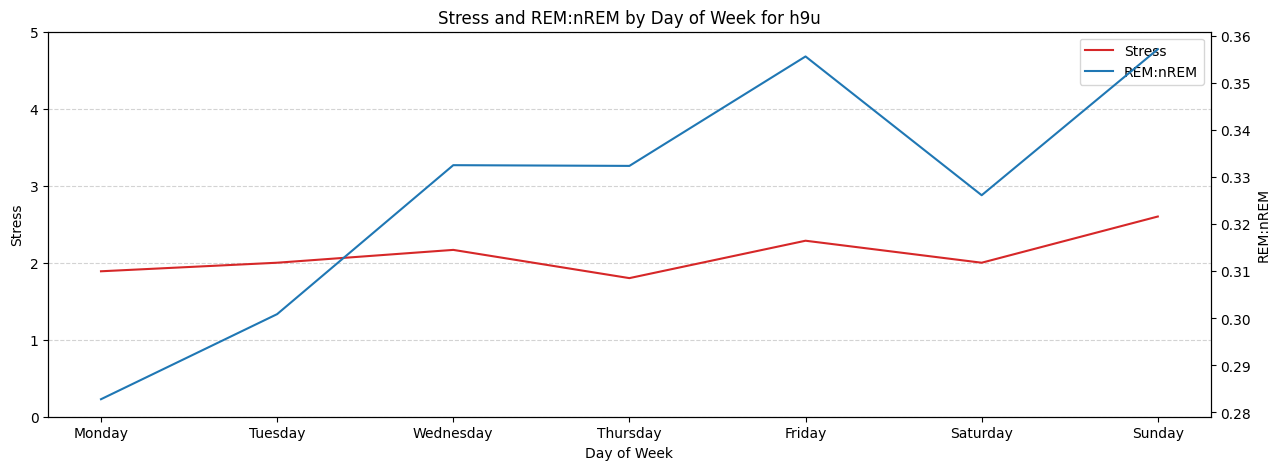

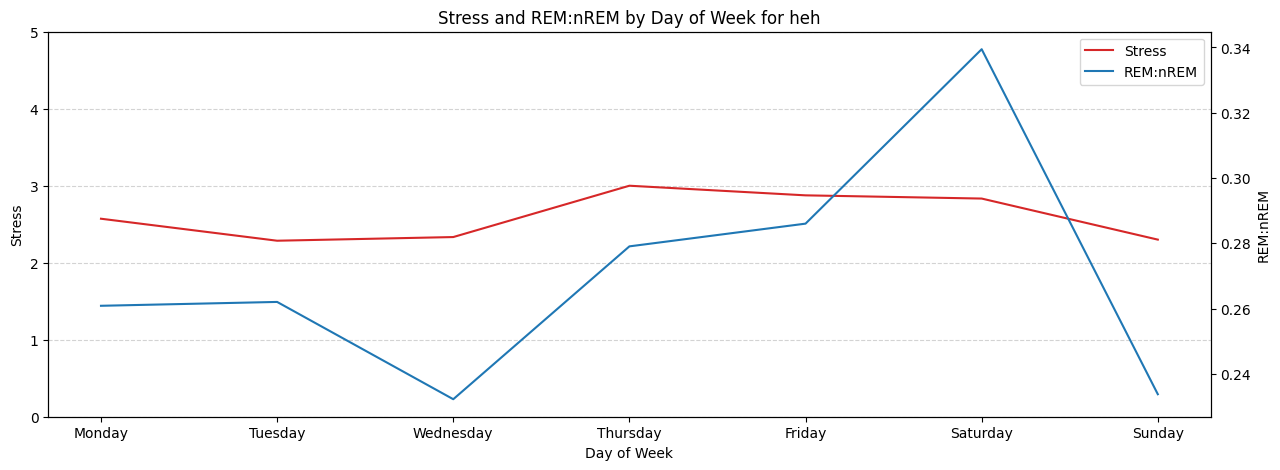

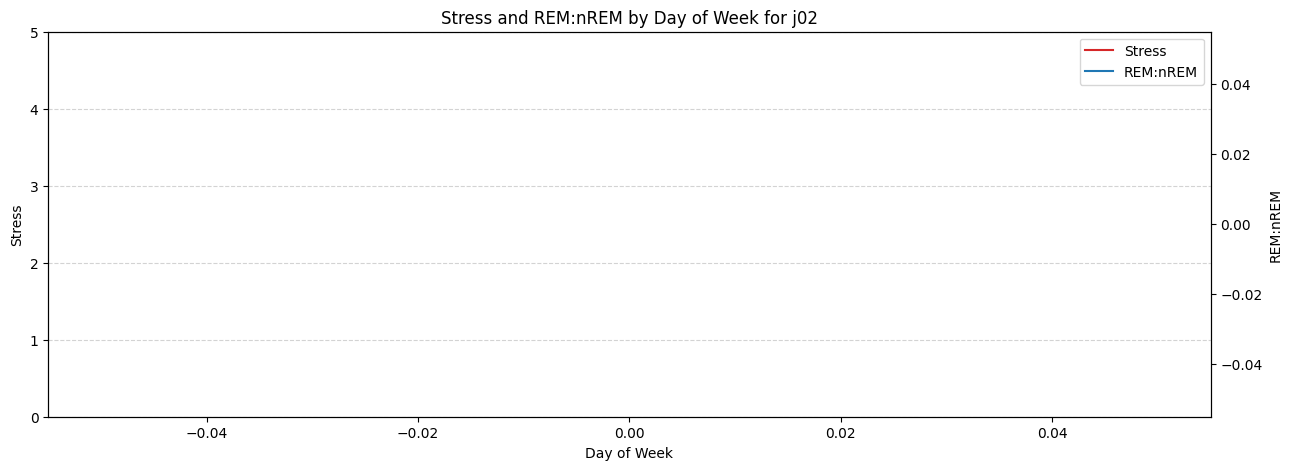

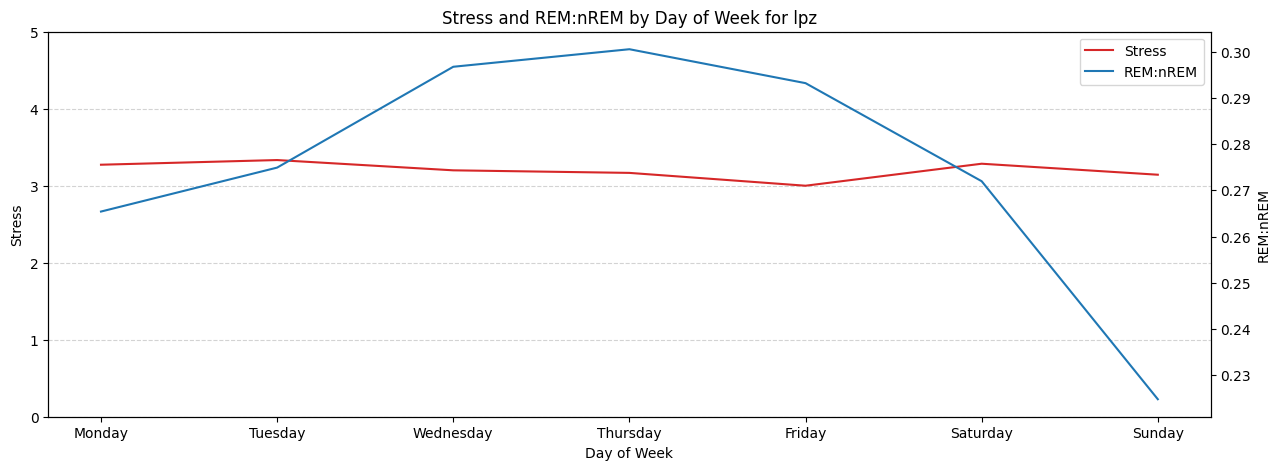

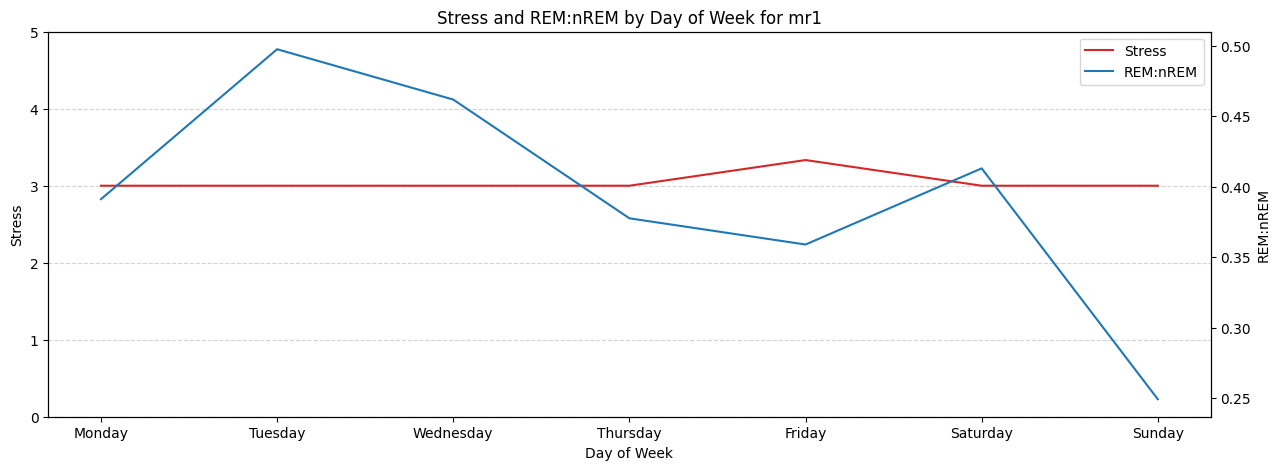

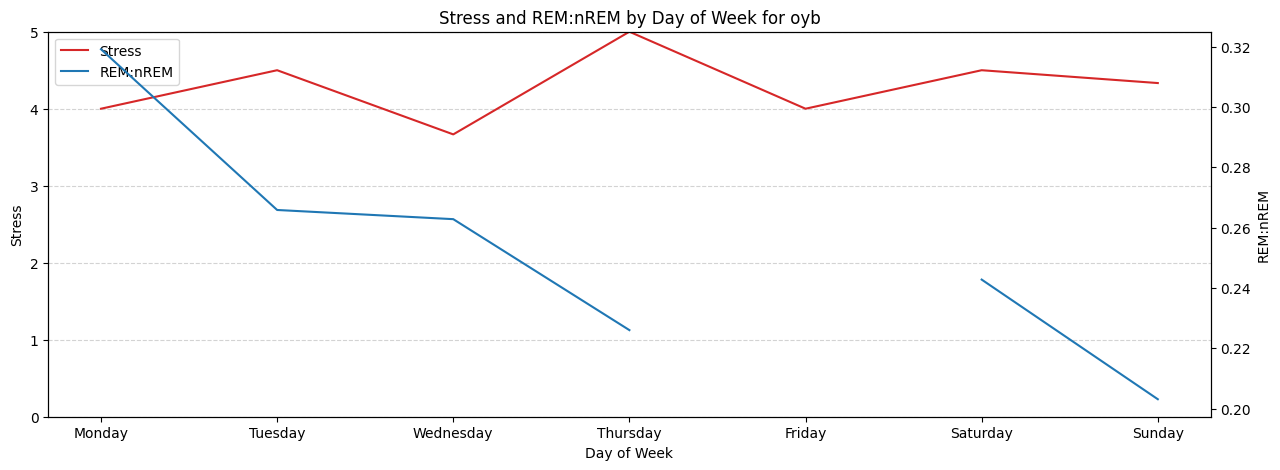

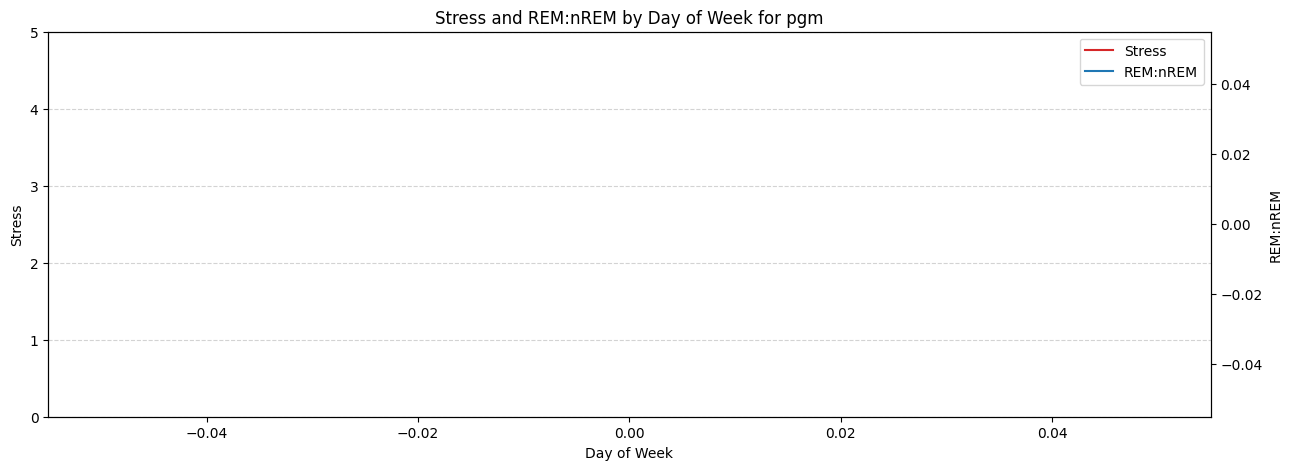

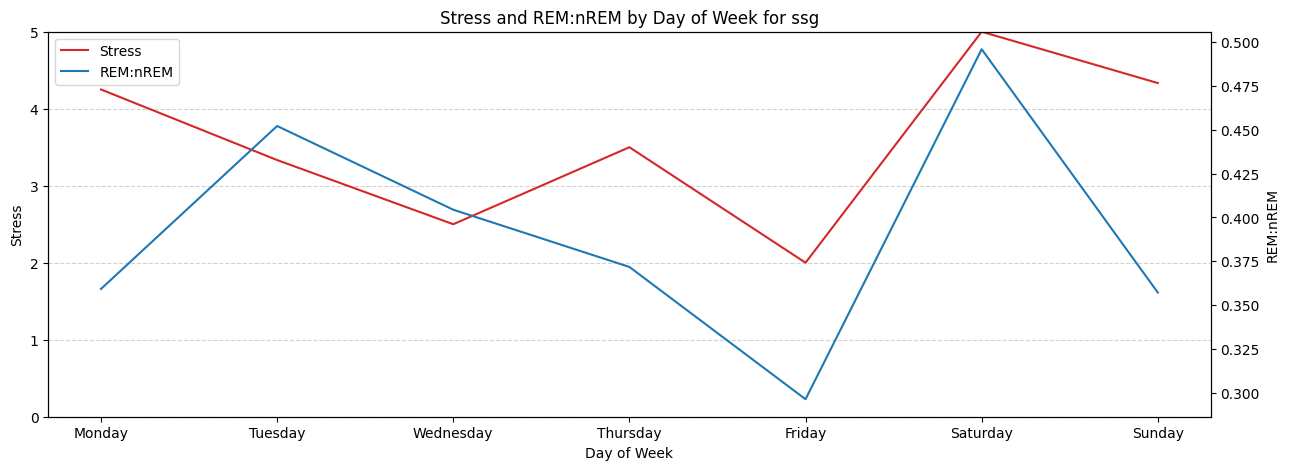

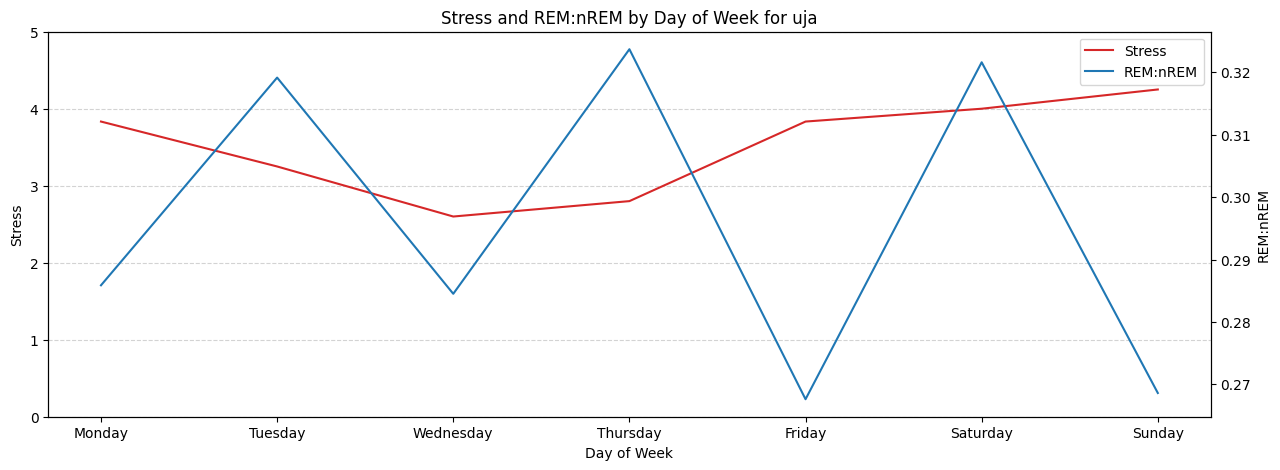

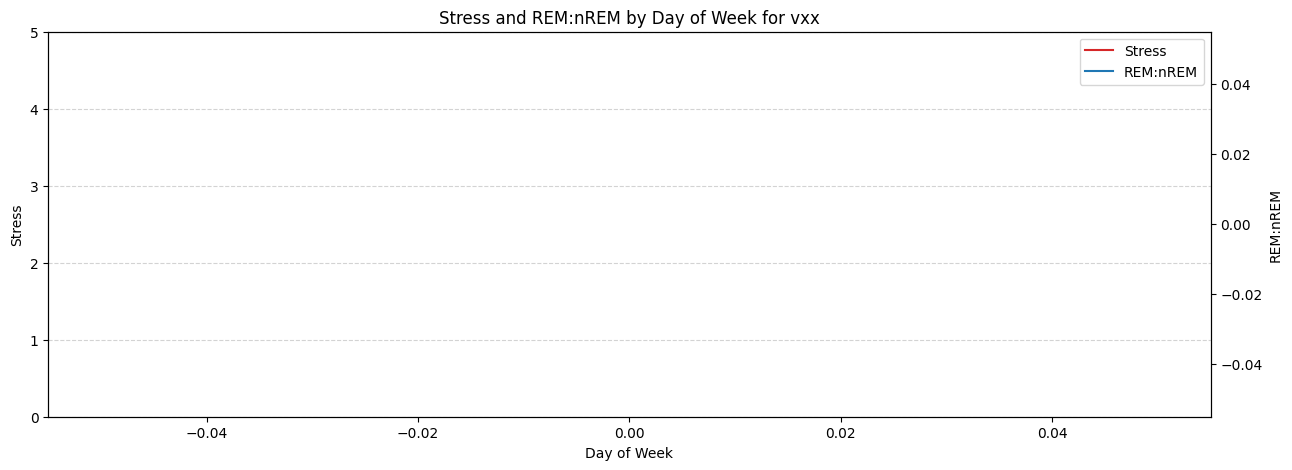

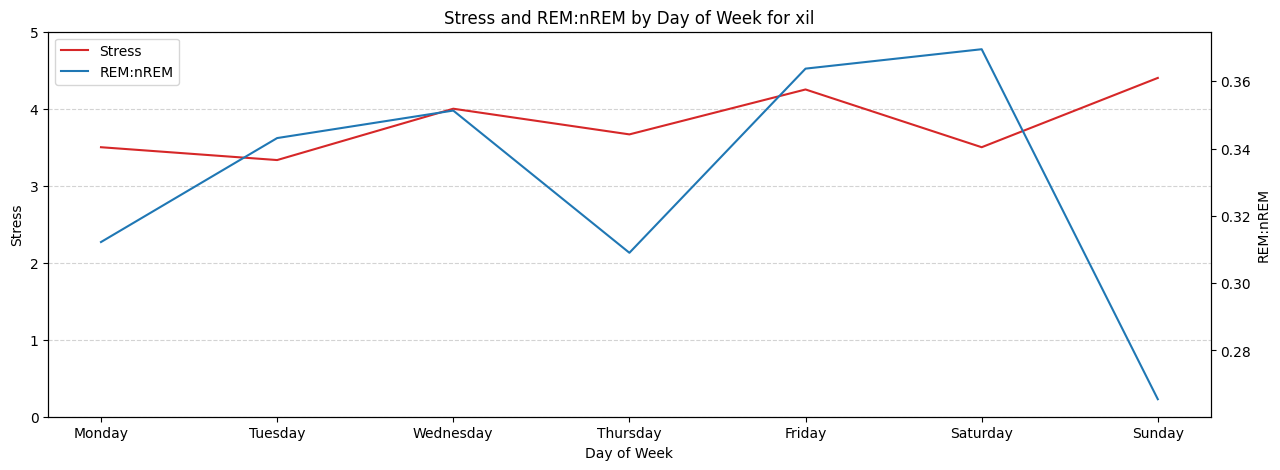

In [40]:
# plot stress and REM:nREM in df for each participant for each day_name ordered from Monday to Sunday
# be able to select which participant to plot by pid in dropdown where REM:nREM has second y axis
# stress and REM:nREM should be the same color according to pid


# plot from df for first participant
# lg1 = ax.plot(df[df['pid'] == 'edr']['day_name'], df[df['pid'] == 'edr']['stress'], color='tab:red', label='Stress')
# lg2 = ax2.plot(df[df['pid'] == 'edr']['day_name'], df[df['pid'] == 'edr']['REM:nREM'], color='tab:blue', label='REM:nREM')

# plot each participant in pids
for pid in pids:
    fig, ax = plt.subplots(figsize=(15,5))
    ax2 = ax.twinx()

    ax.set_title('Stress and REM:nREM by Day of Week for ' + pid)
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Stress')
    ax2.set_ylabel('REM:nREM')
    
    # set Stress axis 0 to 5
    ax.set_ylim(0,5)
    
    lg1 = ax.plot(df[df['pid'] == pid]['day_name'], df[df['pid'] == pid]['stress'], color='tab:red',label='Stress')
    lg2 = ax2.plot(df[df['pid'] == pid]['day_name'], df[df['pid'] == pid]['REM:nREM'], color='tab:blue',label='REM:nREM')
    # one legend
    leg = lg1 + lg2
    labs = [l.get_label() for l in leg]
    ax.legend(leg, labs, loc=0)

    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    # ax.set_xticks(df[df['pid'] == 'edr']['day_name'])
plt.show()


In [41]:
# plot stress in df for each participant for each day_name ordered from Monday to Sunday
fig = px.line(df, x="day_name", y="stress", color="pid", 
                labels={
                    "stress": "Stress",
                    "day_name": "Day of Week",
                    "pid": "Participants"
                })
# fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig.show()



In [42]:
# plot Stress agaisnt TST for each participant
fig = px.scatter(slpsteps, x="TST", y="stress", color="pid", trendline="ols", #points="all",
                labels={
                    "stress": "Stress",
                    "TST": "Total Sleep Time (hr)",
                    "pid": "Participants"
                })
fig.show()

In [43]:
# plot Sleep Rating against TST for each participant
fig = px.scatter(slpsteps, x="TST", y="sleep", trendline="ols",
                labels={
                    "sleep": "Sleep Rating",
                    "TST": "Total Sleep Time (hr)",
                    "pid": "Participants"
                })
# remove visible attribute
# fig.update_traces(visible=False, selector=dict(mode="markers"))
# show legend
# fig.update_layout(showlegend=True)
fig.show()

In [44]:
slpsteps.columns

Index(['pid', 'group', 'wakeDate', 'day_name', 'bedtime', 'wakeup', 'duration',
       'TST', 'REM:nREM', 'deep', 'light', 'rem', 'sleep', 'Q4', 'rep_bedtime',
       'rep_wakeup', 'day_before', 'survey_index', 'Unnamed: 0', 'EndDate',
       'activity', 'Q29', 'stress', 'productivity', 'Q27_1', 'Q34',
       'Q34_6_TEXT', 'Q35', 'date', 'steps', 'steps_norm', 'steps_std'],
      dtype='object')

In [45]:
# Create a box plot
fig = px.box(slpsteps, x='sleep', y='TST', title='Sleep Ratings vs. Total Sleep Time')

# Show the plot
fig.show()

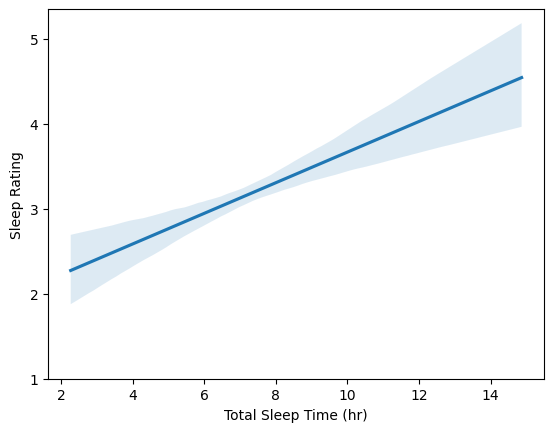

In [46]:
# Create a box plot with switched axes
# fig = px.box(slpsteps, x='sleep', y='TST', title=f'Total Sleep Time vs. Sleep Ratings')

# Add a trendline
sns.regplot(x='TST', y='sleep', data=slpsteps, scatter=False)
plt.yticks([1,2,3,4,5])
# Customize the axis labels
plt.ylabel('Sleep Rating')
plt.xlabel('Total Sleep Time (hr)')
# Show the plot
plt.show()

In [47]:
# Calculate the correlation coefficient for TST and sleep in slpsteps
r, p_value = stats.pearsonr(slpsteps['TST'], slpsteps['sleep'])

# Define the sample size
n = len(slpsteps['TST'])

# Select the desired confidence level (e.g., 0.95 for 95% confidence)
confidence_level = 0.95

# Calculate the critical value (two-tailed test)
alpha = 1 - confidence_level
df = n - 2  # degrees of freedom
t_critical = stats.t.ppf(1 - alpha / 2, df)

# Calculate the standard error
se = np.sqrt((1 - r**2) / (n - 2))

# Calculate the margin of error
me = t_critical * se

# Calculate the confidence interval
lower_bound = r - me
upper_bound = r + me

# Print the result
print('Pearson Correlation Coefficient:', r)
print('Confidence Interval:', (lower_bound, upper_bound))
print('Margin of Error:', me)

Pearson Correlation Coefficient: 0.249745675728253
Confidence Interval: (0.15021404175959197, 0.34927730969691406)
Margin of Error: 0.09953163396866105


In [48]:
# plot productivity against TST for each participant
fig = px.scatter(slpsteps, x="TST", y="productivity", color="pid", trendline="ols", #points="all",
                labels={
                    "productivity": "Productivity",
                    "TST": "Total Sleep Time (hr)",
                    "pid": "Participants"
                })
fig.show()

/Users/beatriceli/miniconda3/envs/wellbeing/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning:

divide by zero encountered in double_scalars



In [49]:
# plot stress against REM:nREM for each participant
fig = px.scatter(slpsteps, x="REM:nREM", y="stress", color="pid", trendline="ols", #points="all",
                labels={
                    "stress": "Stress",
                    "REM:nREM": "REM:nREM",
                    "pid": "Participants"
                })
fig.show()

In [50]:
# plot stress by day of week for each participant
fig = px.box(slpsteps, x="day_name", y="stress", #color="pid", #points="all",
                labels={
                    "stress": "Stress",
                    "day_name": "Day of Week",
                    "pid": "Participants"
                })
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig.show()

In [51]:
# plot Sleep Rating against REM:nREM for each participant
fig = px.scatter(slpsteps, x="REM:nREM", y="sleep", color="pid", trendline="ols", #points="all",
                labels={
                    "sleep": "Sleep Rating",
                    "pid": "Participants"
                })

fig.show()

In [52]:
# how many observations for each participant
slpsteps.groupby('pid').size()

pid
edr    27
egl    44
h9u    58
heh    53
lpz    48
mr1    28
oyb    19
ssg    26
uja    33
xil    32
dtype: int64

In [53]:
# plot productivity against REM:nREM for each participant
fig = px.scatter(slpsteps, x="REM:nREM", y="productivity", color="pid", trendline="ols", #points="all",
                labels={
                    "productivity": "Productivity",
                    "pid": "Participants"
                })
fig.show()


/Users/beatriceli/miniconda3/envs/wellbeing/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning:

divide by zero encountered in double_scalars



In [54]:
# plot productivity against sleep rating for each participant
fig = px.scatter(slpsteps, x="sleep", y="productivity", color="pid", trendline="ols", #points="all",
                labels={
                    "productivity": "Productivity",
                    "sleep": "Sleep Rating",
                    "pid": "Participants"
                })
fig.show()


/Users/beatriceli/miniconda3/envs/wellbeing/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning:

divide by zero encountered in double_scalars



In [55]:
# plot stress against sleep rating for each participant
fig = px.scatter(slpsteps, x="sleep", y="stress", color="pid", trendline="ols", #points="all",
                labels={
                    "stress": "Stress",
                    "sleep": "Sleep Rating",
                    "pid": "Participants"
                })
fig.show()



In [56]:
# plot stress against step count for each participant
fig = px.scatter(slpsteps, x="steps", y="stress", color="pid", trendline="ols", #points="all",
                labels={
                    "stress": "Stress",
                    "steps": "Step Count",
                    "pid": "Participants"
                })
fig.show()


In [57]:
# plot stress against steps_norm for each participant
fig = px.scatter(slpsteps, x="steps", y="sleep", color="pid", trendline="ols", #points="all",
                labels={
                    "sleep": "Sleep Rating",
                    "steps": "Step Count",
                    "pid": "Participants"
                })
fig.show()

In [58]:
# plot sleep rating against step count for each participant
fig = px.scatter(slpsteps, x="steps_std", y="sleep", color="pid", trendline="ols", #points="all",
                labels={
                    "sleep": "Sleep Rating",
                    "steps": "Step Count",
                    "pid": "Participants"
                })
fig.show()

In [59]:
# normaality test for steps for each participant using shapiro-wilk test
# test for normality for each participant
# create empty dataframe to store results of shapiro wilk test for each participant
shapiro_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get sleep duration for each participant
    step = slpsteps[slpsteps['pid'] == i]['steps']
    # run shapiro wilk test
    stat, p = shapiro(step)
    # concat results to shapiro_results dataframe
    shapiro_results = pd.concat([shapiro_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

# get rows where pvalue is less than 0.05
shapiro_results[shapiro_results['pvalue'] < 0.05]

,pid,pvalue
2,h9u,0.000235
4,lpz,0.001623


In [60]:
# plot productivity against step count for each participant
fig = px.scatter(slpsteps, x="steps_std", y="productivity", color="pid", trendline="ols", #points="all",
                labels={
                    "productivity": "Productivity",
                    "steps_std": "Standardardized Step",
                    "pid": "Participants"
                })
fig.show()


/Users/beatriceli/miniconda3/envs/wellbeing/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning:

invalid value encountered in double_scalars



In [61]:
# create week column where values are either weekday or weekend
slpsteps['week'] = slpsteps['day_name'].apply(lambda x: 'weekday' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'weekend')


In [62]:
# compare REM:nREM between weekday and weekend
fig = px.box(slpsteps, x="week", y="REM:nREM", #color="pid", #points="all",
                labels={
                    "week": "Weekday or Weekend",
                    "pid": "Participants"
                })
fig.show()


In [63]:
# compare TST between weekday and weekend
fig = px.box(slpsteps, x="week", y="TST", #color="pid", #points="all",
                labels={
                    "week": "Weekday or Weekend",
                    "pid": "Participants"
                })
fig.show()

In [64]:
# get number of rows for each participant that are weekday and weekend
slpsteps.groupby(['pid', 'week']).size()

pid  week   
edr  weekday    25
     weekend     2
egl  weekday    33
     weekend    11
h9u  weekday    40
     weekend    18
heh  weekday    37
     weekend    16
lpz  weekday    34
     weekend    14
mr1  weekday    19
     weekend     9
oyb  weekday    11
     weekend     8
ssg  weekday    18
     weekend     8
uja  weekday    26
     weekend     7
xil  weekday    23
     weekend     9
dtype: int64

In [65]:
# check if there is statistically significant difference between weekday and weekend REM:nREM using t-test
# create empty dataframe to store results of t-test for each participant
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get REM:nREM for each participant
    REMnREM = slpsteps[slpsteps['pid'] == i]['REM:nREM']
    # run t-test
    stat, p = ttest_ind(REMnREM[REMnREM.index.isin(slpsteps[slpsteps['week'] == 'weekday'].index)], REMnREM[REMnREM.index.isin(slpsteps[slpsteps['week'] == 'weekend'].index)])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

,pid,pvalue
0,edr,NaN
1,egl,0.340355
2,h9u,NaN
3,heh,0.755122
4,lpz,NaN
5,mr1,0.029346
6,oyb,NaN
7,ssg,0.952770
8,uja,0.944223
9,xil,0.605167


In [66]:
# check if there is statistically significant difference between weekday and weekend TST using t-test
# create empty dataframe to store results
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get TST for each participant
    tst = slpsteps[slpsteps['pid'] == i]['TST']
    # run t-test
    stat, p = ttest_ind(tst[slpsteps['week'] == 'weekday'], tst[slpsteps['week'] == 'weekend'])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

,pid,pvalue
0,edr,0.160678
1,egl,0.358753
2,h9u,0.882308
3,heh,0.217539
4,lpz,0.552578
5,mr1,0.684364
6,oyb,0.792302
7,ssg,0.661411
8,uja,0.799820
9,xil,0.526139


In [67]:
# check if there is statistically significant difference between weekday and weekend sleep rating using t-test
# create empty dataframe to store results
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get sleep rating for each participant
    sleep = slpsteps[slpsteps['pid'] == i]['sleep']
    # run t-test
    stat, p = ttest_ind(sleep[slpsteps['week'] == 'weekday'], sleep[slpsteps['week'] == 'weekend'])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_83363/783373912.py:10: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,pid,pvalue
0,edr,0.926195
1,egl,0.383019
2,h9u,0.882177
3,heh,0.571954
4,lpz,0.484081
5,mr1,0.382292
6,oyb,0.760152
7,ssg,0.400833
8,uja,0.924164
9,xil,0.782914


In [68]:
# check if there is statistically significant difference between weekday and weekend productivity using t-test
# create empty dataframe to store results
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get productivity for each participant
    prod = slpsteps[slpsteps['pid'] == i]['productivity']
    # run t-test
    stat, p = ttest_ind(prod[slpsteps['week'] == 'weekday'], prod[slpsteps['week'] == 'weekend'])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_83363/3873438777.py:10: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,pid,pvalue
0,edr,0.929148
1,egl,0.569819
2,h9u,0.101207
3,heh,0.302884
4,lpz,0.268347
5,mr1,NaN
6,oyb,0.361577
7,ssg,0.058601
8,uja,0.532291
9,xil,0.176089


In [69]:
# check if there is statistically significant difference between weekday and weekend stress using t-test
# create empty dataframe to store results
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get stress for each participant
    stress = slpsteps[slpsteps['pid'] == i]['stress']
    # run t-test
    stat, p = ttest_ind(stress[slpsteps['week'] == 'weekday'], stress[slpsteps['week'] == 'weekend'])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_83363/1574821872.py:10: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,pid,pvalue
0,edr,0.598222
1,egl,0.171624
2,h9u,0.137367
3,heh,0.713636
4,lpz,0.973048
5,mr1,0.501652
6,oyb,0.796958
7,ssg,0.027001
8,uja,0.021673
9,xil,0.436257


In [70]:
# to csv
slpsteps.to_csv('processed_data/slpsteps.csv', index=False)